# Inertial Measurement Unit (IMU) Calibration

Kevin J. Walchko

7 July 2019

---

Calibrating an IMU

Robot: Nav
Processor: Raspberry Pi 3B+
IMU: [NXP IMU](https://github.com/MomsFriendlyRobotCompany/nxp_imu)

## References

- [Wikipedia MEMS](https://en.wikipedia.org/wiki/Microelectromechanical_systems)
- [Simple Calibration Routine](https://github.com/kriswiner/MPU6050/wiki/Simple-and-Effective-Magnetometer-Calibration)
- [Calibration Routine](http://www.sensorsmag.com/components/compensating-for-tilt-hard-iron-and-soft-iron-effects)
- [Hard/Soft Iron Effects](https://www.phidgets.com/docs/Magnetometer_Primer)
- [Wikipedia: Earth's magnetic field](https://en.wikipedia.org/wiki/Earth%27s_magnetic_field)
- [NASA: Earth's Pole Reversal](https://www.nasa.gov/topics/earth/features/2012-poleReversal.html)
- [Wikipedia: Tesla (unit)](https://en.wikipedia.org/wiki/Tesla_(unit))
- [C version](https://github.com/TobiasSimon/MadgwickTests/blob/master/MadgwickAHRS.c)
- [Low Cost Inertial Navigation](https://walchko.github.io/Publications/walchko-MS-EE.pdf)

## Setup

In [1]:
%matplotlib inline

In [10]:
import numpy as np
import the_collector
from the_collector import BagIt, Pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

In [11]:
print("Using the_collector version:", the_collector.__version__)

Using the_collector version: 0.8.0


# Various Function

This section holds various functions to format, display, or whatever. These are used in the following sections without much of an explaination. The code and comments are below if you really want to know.

In [18]:
# already ins_nav.utils ... why not use that?
def normalize(x, y, z):
    """Return a unit vector"""
    norm = sqrt(x * x + y * y + z * z)
    if norm > 0.0:  # why did I do this?
        inorm = 1/norm  # why did I do this?
        x *= inorm
        y *= inorm
        z *= inorm
    else:
        raise ZeroDivisionError('division by zero: {} {} {}'.format(x, y, z))
    return (x, y, z)

In [19]:
def plotArray(data, dt=None, title=None):
    """
    Plots the x, y, and z components of a sensor.
    
    In:
        title - what you want to name something
        [[x,y,z],[x,y,z],[x,y,z], ...]
    Out:
        None
    """
    if dt is None:
        dt = range(len(data))
        
    plt.subplot(3,1,1)
    plt.plot(dt, [x[0] for x in data])
    plt.ylabel('x')
    plt.grid(True)
    if title:
        plt.title(title)
    
    plt.subplot(3,1,2)
    plt.plot(dt, [x[1] for x in data])
    plt.ylabel('y')
    plt.grid(True)
    
    plt.subplot(3,1,3)
    plt.plot(dt, [x[2] for x in data])
    plt.ylabel('z')
    plt.grid(True)

In [21]:
def apply_calibration(data, bias):
    """
    Given the data and the bias, correct the data 
    """
    c_data = []
    for d in data:
        t = []
        for i in [0,1,2]:
            t.append(d[i]-bias[i])
        c_data.append(t)
            
    return c_data

In [55]:
def split_xyz(data):
    """
    Break out the x, y, and z into it's own array for plotting
    """
    xx = []
    yy = []
    zz = []
    for v in data:
        xx.append(v[0])
        yy.append(v[1])
        zz.append(v[2])
    return xx, yy, zz

def plotMagnetometer3D(data, title=None):
    x,y,z = split_xyz(data)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(x, y, z, '.b');
    ax.set_xlabel('$\mu$T')
    ax.set_ylabel('$\mu$T')
    ax.set_zlabel('$\mu$T')
    if title:
        plt.title(title);

def plotMagnetometer(data, title=None):
    x,y,z = split_xyz(data)
    plt.plot(x,y,'.b', x,z,'.r', z,y, '.g')
    plt.xlabel('$\mu$T')
    plt.ylabel('$\mu$T')
    plt.axis('equal')
    plt.grid(True);
    plt.legend(['x', 'y', 'z'])
    if title:
        plt.title(title);

# Get Sensor Data

First lets spin around the imu and grab lots of data in different orientations. This is done on a high precision "lazy susan" from [Walmart](https://www.walmart.com/ip/Mainstays-Lazy-Susan-Bamboo/21950041).

![](pics/lazy-susan.jpg)

Here are are collecting the accel, mag, gyro, and video data. Remeber, at each time step, `bagit` appends a timestamp to each of these data samples. We will have to pull those off so we can work with the data and plot it correctly.

In [5]:
from collections import namedtuple

Data = namedtuple('Data', 'data timestamp')

In [43]:
# NXP IMU
bag = BagIt(Pickle)
cal = bag.read('data-tumble.pickle.bag')

# let's list the keys and make it look pretty
print('Bag keys:')
print('-'*30)
for k in cal.keys():
    print('  {:7}: {}'.format(k, len(cal[k])))

>>  pickle
>> Reading[pickle]: data-tumble.pickle.bag
Bag keys:
------------------------------
  accel  : 10000
  mag    : 10000
  gyro   : 10000


In [44]:
print("Data Rate: {:.0f} Hz".format(
    len(cal['accel'])/(cal['accel'][-1].timestamp - cal['accel'][0].timestamp))
)

Data Rate: 196 Hz


# Magnetometer Calibration

First let's take a look at the raw data.

In [65]:
# remember, each data sample has a time stamp applied
# for plotting, let's separate the timestamp (x-axis) and the data (y-axis)
# accel = [x.data for x in cal['accel']]
mag = [x.data for x in cal['mag']]
# gyro = [x.data for x in cal['gyro']]

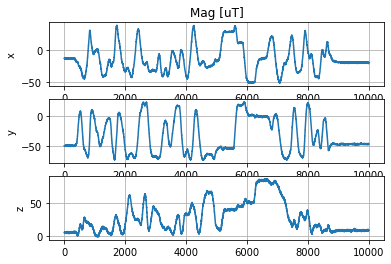

In [66]:
# magnetometer measures Earth's magnetic field
plotArray(mag, title='Mag [uT]')

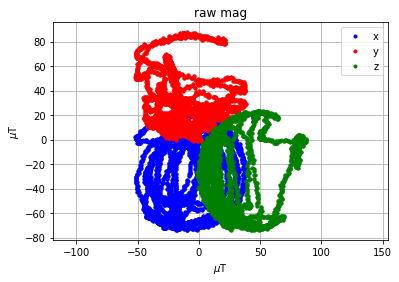

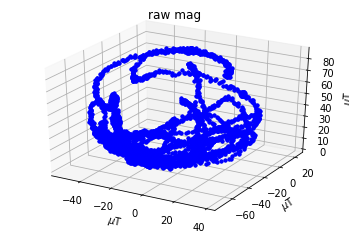

In [67]:
# now, ideally these should be an ellipsoid centered around 0.0
# but they aren't ... need to fix the bias (offset)
plotMagnetometer(mag, 'raw mag')
plotMagnetometer3D(mag, 'raw mag')

To compensate and recenter, for each axis (x,y,z), we will calculate the mean offset ($\alpha$):

$$
\alpha_x = \frac{x_{max} + x_{min}}{2} \\
mag_{corrected} = mag_{raw} - \alpha_x
$$

In [68]:
def find_mag_calibration(mag):
    """
    Go through the raw data and find the max/min for x, y, z
    """
    max_m = [-1000]*3
    min_m = [1000]*3
    for m in mag:
        for i in range(3):
            max_m[i] = m[i] if m[i] > max_m[i] else max_m[i]
            min_m[i] = m[i] if m[i] < min_m[i] else min_m[i]
    bias = [0]*3
    for i in range(3):
        bias[i] = (max_m[i] + min_m[i])/2
    return bias

In [69]:
# so let's find the bias needed to correct the imu
bias = find_mag_calibration(mag)
print('bias', bias)

bias [-6.949999999999999, -25.15, 43.2]


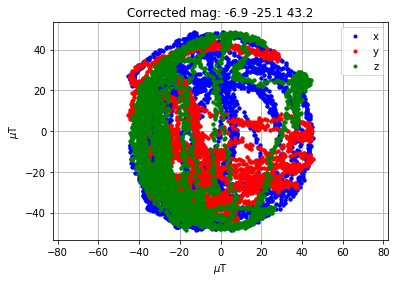

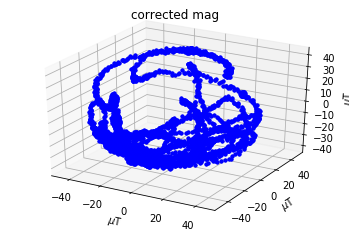

In [71]:
# now the data should be nicely centered around (0,0,0)
cm = apply_calibration(mag, bias)
plotMagnetometer(cm, 'Corrected mag: {:.1f} {:.1f} {:.1f}'.format(*bias))
plotMagnetometer3D(cm, 'corrected mag')

Notice how the results are centered around zero and look nicely uniform. Remeber, this was very simplistically and without the use of high quality test/measurement equipment, so I wouldn't try to navigate a satellite with this system. However, for our purposes it is fine.

Now using this bias, we should get better performance when reading the compass.

# Accelerometer Calibration

We are not going to do much with the acceleromer or gyro data. Properly calibrating these is much more complex and little biases lead to large errors over time. By comparison, the magnetometers are really simple. 

Generally, our accelerometer model is:

$$
\begin{bmatrix}
  a_x \\
  a_y \\
  a_z
\end{bmatrix}_{meas} = 
\begin{bmatrix}
  1 & M_{xy} & M_{xz} \\
  M_{yx} & 1 & M_{yz} \\
  M_{zx} & M_{zy} & 1
\end{bmatrix} 
\begin{bmatrix}
  s_x & 0 & 0 \\
  0 & s_y & 0 \\
  0 & 0 & s_z
\end{bmatrix}
\begin{bmatrix}
  a_x \\
  a_y \\
  a_z
\end{bmatrix}_{inertial}+
\begin{bmatrix}
  bias_x \\
  bias_y \\
  bias_z
\end{bmatrix}
$$

where $M_{xyz}$ are the axis coupling terms which come from small error due to the accelerometers not being orthogonal, $s_{xyz}$ are scaling errors which arise from error in reading the true value of the gravity, $a_{meas}$ are the noisy measured acceration values, and $a_{inertial}$ are the real clean acceleration terms. You have to go through a complicated calibration process to determine what these values really are ... it is  a lot of work.

We are going to do a very simple calibration on our accelerometer. Since our system is always in one orientation, we know gravity is always facing down. Therefore, we are just going to take the mean value and subtract it from [0, 0, 1].

>> Reading[pickle]: data-still.pickle.bag
Acceleration bias: 0.0177 -0.0315 0.0242


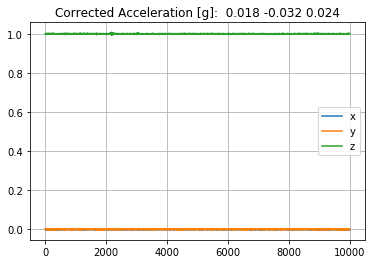

In [73]:
def find_accel_calibration(a, ref):
    # we expect to see [0,0,1], so we will find the average offset from
    # that value and use it as the bias ... this is far from the best
    # way to do this in the real world.
    # x,y,z = split_xyz(a)
    xx = np.mean([x[0] for x in a])
    yy = np.mean([x[1] for x in a])
    zz = np.mean([x[2] for x in a])
    
    return (xx - ref[0], yy - ref[1], zz - ref[2],)


still_cal = bag.read('data-still.pickle.bag')
saccel = [x.data for x in still_cal['accel']]

a_bias = find_accel_calibration(saccel, [0,0,1])
print('Acceleration bias: {:.4f} {:.4f} {:.4f}'.format(*a_bias))

ca = apply_calibration(saccel, a_bias)

plt.plot([x[0] for x in ca], label='x')
plt.plot([x[1] for x in ca], label='y')
plt.plot([x[2] for x in ca], label='z')
plt.title('Corrected Acceleration [g]:  {:.3f} {:.3f} {:.3f}'.format(*a_bias))
plt.legend()
plt.grid(True);

In [59]:
np.mean([x[2] for x in ca])

1.0000000000000004

# Gyroscope Calibration

For this we will also use the data of the IMU sitting still. Since it follows the same idea as the acceleration, we will use the acceleration functions to find the bias.

In [61]:
sg = [x.data for x in still_cal['gyro']]

g_bias = find_accel_calibration(sg, [0,0,0])
print('Acceleration bias: {:.4f} {:.4f} {:.4f}'.format(*g_bias))

Acceleration bias: 0.7712 -1.0839 -0.1098



-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

# Check Calibration

So lets take the calibrated sensor readings now and display the heading (yaw) of the system.

In [64]:
import ins_nav
from ins_nav.ahrs import AHRS
ahrs = AHRS()
beta = 1.0
dt = 1/20
save_r = []
save_p = []
save_y = []
for a, m, g in zip(accel, cm, gyro):
    q = ahrs.updateAGM(a,m,g,beta,dt)
    r,p,y = quat2euler(*q, degrees=True)
    save_r.append(r)
    save_p.append(p)
    save_y.append(y)
    
for i, (d, l) in enumerate(zip([save_r, save_p, save_y],['Roll','Pitch','Yaw'])):
    plt.subplot(3,1,i+1);
    plt.plot(d);
    plt.grid(True)
    plt.ylabel(l)

ModuleNotFoundError: No module named 'ins_nav'

In [26]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

rc('animation', html='html5')

def plot_lidar_range(lidar, fname=None):
    """
    lidar - rangle data
    fname - file name to save mp4 to
    """
    def update_line(num, scans, theta, line):
        scan = scans[num]
        offsets = np.array([(th, rng) for th, rng in zip(theta, scan)])
        line.set_offsets(offsets)
        intens = np.array([meas for meas in scan])
        line.set_array(intens)
        return line,

    dmax = 0
    for scan in lidar:
        for d in scan:
            dmax = d if d > dmax else dmax

    theta = [i*2*pi/360 for i in range(360)]

    fig = plt.figure()
    fig.suptitle('Range [m]')
    ax = plt.subplot(111, projection='polar')
    line = ax.scatter([0, 0], [0, 0])
    ax.set_rmax(1.25*dmax)
    ax.grid(True)

    ani = animation.FuncAnimation(
        fig,
        update_line,
        fargs=(lidar, theta, line),
        interval=100,
        frames=len(lidar),
        blit=True)
    
    if fname:
        ani.save(fname)
        
    return ani